In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import wquantiles as wq
import statsmodels.api as stm
import seaborn as sns

### 1. Estimates of location

In [26]:
df = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/state.csv")
df.head(3)

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ


In [27]:
print("Mean Population: ", df['Population'].mean())
print("Trimmed Mean Population: ", st.trim_mean(df['Population'], 0.10))
print("Median Population: ", df['Population'].median())
print("\nWeighted(Murder.Rate) Mean Population: ", np.average(df['Murder.Rate'], weights=df['Population']))
print("Weighted(Murder.Rate) Median Population: ", wq.median(df['Murder.Rate'], weights=df['Population']))

Mean Population:  6162876.3
Trimmed Mean Population:  4783697.125
Median Population:  4436369.5

Weighted(Murder.Rate) Mean Population:  4.445833981123393
Weighted(Murder.Rate) Median Population:  4.4


### 2. Estimates of Variablity

In [28]:
print("Std. Deviation: ", df['Population'].std())
print("IQR: ", (df['Population'].quantile(0.75)- df['Population'].quantile(0.25)))
print("Median Absolute Deviation from Median: ", stm.robust.scale.mad(df['Population']))

df['Population'].quantile([0.25, 0.5, 0.75])

Std. Deviation:  6848235.347401142
IQR:  4847308.0
Median Absolute Deviation from Median:  3849876.1459979336


0.25    1833004.25
0.50    4436369.50
0.75    6680312.25
Name: Population, dtype: float64

Text(0, 0.5, 'Population (Millions)')

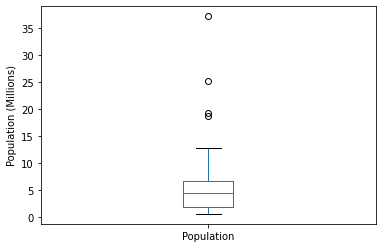

In [29]:
ax = (df['Population'] / 1_000_000).plot.box()
ax.set_ylabel("Population (Millions)")

### 3. Frequency Tables and Histograms

In [30]:
binnedPopulation = pd.cut(df['Population'], 10)
binnedPopulation.value_counts()

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64

In [31]:
binnedPopulation.name = "binnedPopulation"

df = pd.concat([df, binnedPopulation], axis=1)
df.sort_values(by="Population")

groups = []
for group, subset in df.groupby(by="binnedPopulation"):
    groups.append({
        "BinRange": group,
        "Count": len(subset),
        "States":",".join(subset.Abbreviation)
    })

In [32]:
pd.DataFrame(groups)

,BinRange,Count,States
0,"(526935.67, 4232659.0]",24,"AK,AR,CT,DE,HI,ID,IA,KS,ME,MS,MT,NE,NV,NH,NM,N..."
1,"(4232659.0, 7901692.0]",14,"AL,AZ,CO,IN,KY,LA,MD,MA,MN,MO,SC,TN,WA,WI"
2,"(7901692.0, 11570725.0]",6,"GA,MI,NJ,NC,OH,VA"
3,"(11570725.0, 15239758.0]",2,"IL,PA"
4,"(15239758.0, 18908791.0]",1,FL
5,"(18908791.0, 22577824.0]",1,NY
6,"(22577824.0, 26246857.0]",1,TX
7,"(26246857.0, 29915890.0]",0,
8,"(29915890.0, 33584923.0]",0,
9,"(33584923.0, 37253956.0]",1,CA


This gives us range 33,584,923-526,935 which we are supposed to divide up into equal size bins, ex 10 bins. So each binsize will be 3,3057,98.  

Text(0.5, 0, 'Population (millions)')

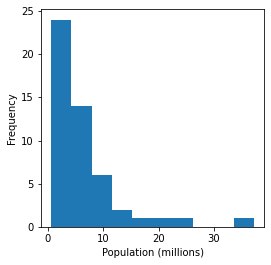

In [33]:
ax = (df['Population']/1_000_000).plot.hist(figsize=(4,4), bins=10)
ax.set_xlabel('Population (millions)')

### 4. Density Plots and Estimates

Text(0.5, 0, 'Murder Rate (per 100,000)')

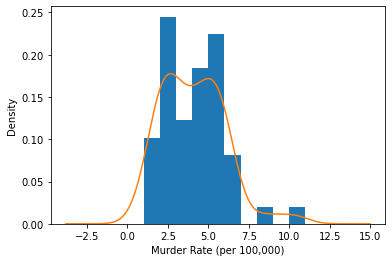

In [34]:
ax = df['Murder.Rate'].plot.hist(density= True, bins= range(1,12))
df['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel("Murder Rate (per 100,000)")

### 5. Exploring Binary and Categorical Data

In [35]:
dfw = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/dfw_airline.csv")
dfw.head(2)

,Carrier,ATC,Weather,Security,Inbound
0,64263.16,84856.5,11235.42,343.15,118427.82


Text(0, 0.5, 'Count')

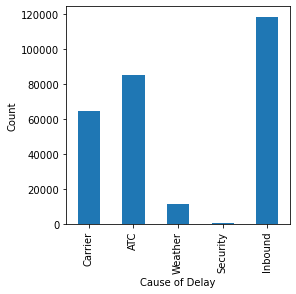

In [37]:
ax = dfw.transpose().plot.bar(figsize=(4,4), legend=False)
ax.set_xlabel("Cause of Delay")
ax.set_ylabel("Count")

### 6. Correlation

In [40]:
sp500_sym = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/sp500_sectors.csv")
sp500_px = pd.read_csv("https://github.com/gedeck/practical-statistics-for-data-scientists/raw/master/data/sp500_data.csv.gz", compression="gzip", index_col=0)

<AxesSubplot:>

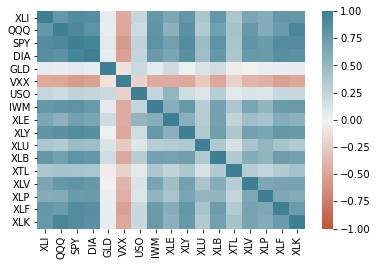

In [48]:
symbols = sp500_sym.loc[sp500_sym['sector'] == 'etf']['symbol']

etfs = sp500_px.loc[sp500_px.index >= '2012-07-01', symbols]
sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
           cmap=sns.diverging_palette(20, 220, as_cmap=True))

Following code shows strength of the correlation using ellipses

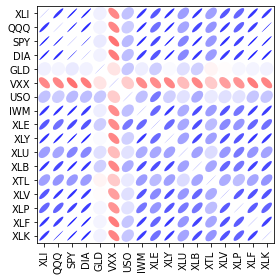

In [51]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec
#fig, ax = plt.subplots(figsize=(5, 4))
m = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
#cb = fig.colorbar(m)
#cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

In [52]:
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

# Filter data for dates July 2012 through June 2015
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]

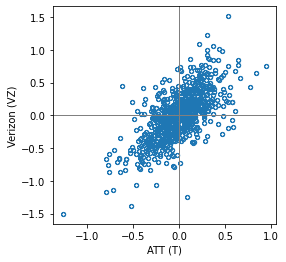

In [55]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4,4), marker="$\u25EF$")
ax.set_xlabel("ATT (T)")
ax.set_ylabel("Verizon (VZ)")
ax.axhline(0, color='gray', lw=1)
ax.axvline(0, color='gray', lw=1)

We can see that returns have positive relationship: while they cluster around zero, on most days stock goes up or go down in tandem (upper right or lower left quadrants).  
There are fewer days where one stock goes down significantly while other stock goes up or vice versa (upper left or lower right quadrants).  
Also even if there are only 754 data points, it's still difficult to identify details in the middle of the plot. By adding transperancy or using hexagonal binning and density plots, we can find additonal structures.  

### 7. Exploring Two or More Variables  
#### a. Plotting Numerical vs Numerical Data
- Hexagonal Bins
- Contours

In [2]:
kc_tax = pd.read_csv("https://github.com/gedeck/practical-statistics-for-data-scientists/raw/master/data/kc_tax.csv.gz", compression="gzip")

In [3]:
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750_000) &
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), 
                     :]
kc_tax0.shape

(432693, 3)

If the number of data points gets large, scatter plots will no longer be meaningful.   

Text(0, 0.5, 'Tax-Assessed Value')

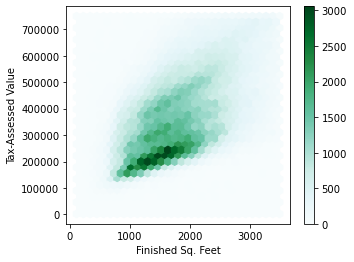

In [4]:
ax = kc_tax0.plot.hexbin(x="SqFtTotLiving", y="TaxAssessedValue", 
                        gridsize=30, sharex=False, figsize=(5,4))
ax.set_xlabel("Finished Sq. Feet")
ax.set_ylabel("Tax-Assessed Value")

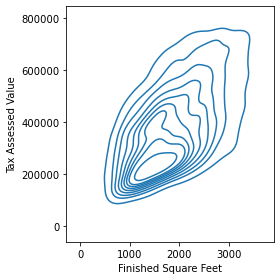

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=kc_tax0.sample(10000), x='SqFtTotLiving', y='TaxAssessedValue', ax=ax)
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

#### b. Plotting Two Categorical Variables
- Contingency Table

In [6]:
lc_loans = pd.read_csv("https://github.com/gedeck/practical-statistics-for-data-scientists/raw/master/data/lc_loans.csv")
lc_loans.head(2)

,status,grade
0,Fully Paid,B
1,Charged Off,C


In [8]:
crosstab= lc_loans.pivot_table(index="grade", columns="status",
                              aggfunc=lambda x: len(x), margins=True)

df = crosstab.loc['A':'G', :].copy()
df.loc[:, 'Charged Off':'Late'] = df.loc[:, 'Charged Off':'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
perc_crosstab

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,0.021548,0.690454,0.281528,0.006470,0.160746
B,0.040054,0.709013,0.235401,0.015532,0.293529
C,0.049828,0.735702,0.191495,0.022974,0.268039
D,0.067410,0.717328,0.184189,0.031073,0.164708
E,0.081657,0.707936,0.170929,0.039478,0.077177
F,0.118258,0.654371,0.180409,0.046962,0.028614
G,0.126196,0.614008,0.198396,0.061401,0.007187


#### c. Categorical and Numerical Data
- Boxplots : More clearly shows outliers
- Violin Plot : Shows naunces in the distribution that aren't perceptible in box plots

In [9]:
airline_stats = pd.read_csv("https://github.com/gedeck/practical-statistics-for-data-scientists/raw/master/data/airline_stats.csv")
airline_stats.head(3)

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American


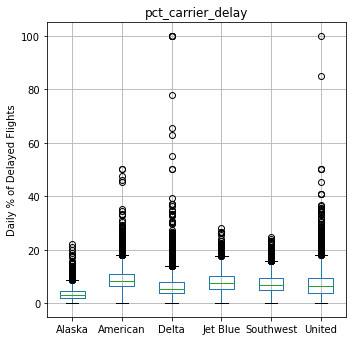

In [13]:
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay', figsize=(5,5))
ax.set_xlabel("")
ax.set_ylabel("Daily % of Delayed Flights")
plt.suptitle('')
plt.tight_layout()
plt.show()

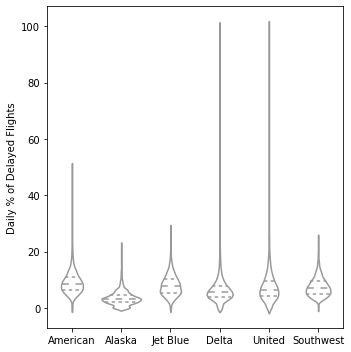

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(data=airline_stats, x='airline', y='pct_carrier_delay',
               ax=ax, inner='quartile', color='white')
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')

plt.tight_layout()
plt.show()

#### d. Visualizing Multiple Variables
- FacetGrid

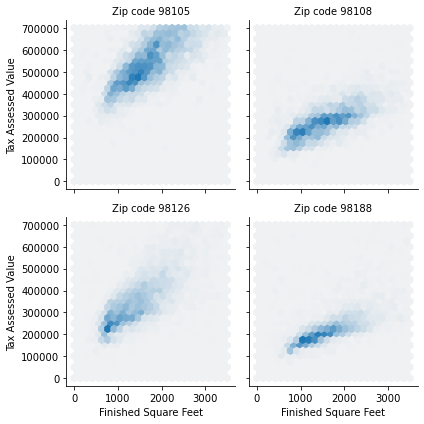

In [18]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()